In [1]:
import matplotlib.pyplot as plt
import sys
import classy
import os
from classy import Class
import chaospy as cp
import pyDOE
import numpy as np
import time
from velocileptors.EPT.cleft_kexpanded_resummed_fftw import RKECLEFT

from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

plt.rcParams['axes.labelsize']        = 14
plt.rcParams['axes.titlesize']        = 14
plt.rcParams['xtick.labelsize']       = 14
plt.rcParams['ytick.labelsize']       = 14
plt.rcParams['font.family']           = 'serif'
plt.rcParams['font.size']             = 14


In [2]:
# full nonlinear P_mms
k, pmm_000 = np.loadtxt('abacus_spectra/ph000_lrg_ext_matter.txt', unpack=True)
k, pmm_001 = np.loadtxt('abacus_spectra/ph001_lrg_ext_matter.txt', unpack=True)
k, pmm_002 = np.loadtxt('abacus_spectra/ph002_lrg_ext_matter.txt', unpack=True)
k, pmm_003 = np.loadtxt('abacus_spectra/ph003_lrg_ext_matter.txt', unpack=True)
k, pmm_004 = np.loadtxt('abacus_spectra/ph004_lrg_ext_matter.txt', unpack=True)
k, pmm_005 = np.loadtxt('abacus_spectra/ph005_lrg_ext_matter.txt', unpack=True)
k, pmm_006 = np.loadtxt('abacus_spectra/ph006_lrg_ext_matter.txt', unpack=True)
k, pmm_007 = np.loadtxt('abacus_spectra/ph007_lrg_ext_matter.txt', unpack=True)
k, pmm_008 = np.loadtxt('abacus_spectra/ph008_lrg_ext_matter.txt', unpack=True)
k, pmm_009 = np.loadtxt('abacus_spectra/ph009_lrg_ext_matter.txt', unpack=True)

# Zel'dovich spectra
k, pmm_ZD_000 = np.loadtxt('abacus_spectra/ph000_lrg_ext_ZD_ZD_m.txt', unpack=True)
k, pmm_ZD_001 = np.loadtxt('abacus_spectra/ph001_lrg_ext_ZD_ZD_m.txt', unpack=True)
k, pmm_ZD_002 = np.loadtxt('abacus_spectra/ph002_lrg_ext_ZD_ZD_m.txt', unpack=True)
k, pmm_ZD_003 = np.loadtxt('abacus_spectra/ph003_lrg_ext_ZD_ZD_m.txt', unpack=True)
k, pmm_ZD_004 = np.loadtxt('abacus_spectra/ph004_lrg_ext_ZD_ZD_m.txt', unpack=True)
k, pmm_ZD_005 = np.loadtxt('abacus_spectra/ph005_lrg_ext_ZD_ZD_m.txt', unpack=True)
k, pmm_ZD_006 = np.loadtxt('abacus_spectra/ph006_lrg_ext_ZD_ZD_m.txt', unpack=True)
k, pmm_ZD_007 = np.loadtxt('abacus_spectra/ph007_lrg_ext_ZD_ZD_m.txt', unpack=True)
k, pmm_ZD_008 = np.loadtxt('abacus_spectra/ph008_lrg_ext_ZD_ZD_m.txt', unpack=True)
k, pmm_ZD_009 = np.loadtxt('abacus_spectra/ph009_lrg_ext_ZD_ZD_m.txt', unpack=True)


In [3]:
z = 0.5
params = {
'output': 'mPk',
'P_k_max_h/Mpc': 100.,
'z_pk': '0.0,%.3f'%(z),
'A_s': 2.0830e-9,
'n_s': 0.9649,
'h': 0.6736,
'N_ur': 2.0308,
'N_ncdm': 1,
'omega_b': 0.02237,
'omega_cdm': 0.1200,
'N_ur': 2.0328,
'N_ncdm': 1,
'omega_ncdm': 0.00064420}

linear = Class()
linear.set(params)
linear.compute()
kk_lin = np.logspace(-3.0,1,700)
pk_lin = np.array([linear.pk(kk*linear.h(), z)*linear.h()**3 for kk in kk_lin])
pk_lin_trunc = np.array([linear.pk(kk*linear.h(), z)*linear.h()**3 for kk in k])

hmcode = Class()
hmcode.set(params)
hmcode.set({'non_linear':'hmcode'})
hmcode.compute()
pk_hmcode = np.array([hmcode.pk(kk*hmcode.h(), z)*hmcode.h()**3 for kk in k])

ept = RKECLEFT(kk_lin, pk_lin, N=5000)
ept.make_ptable(kmin=min(kk_lin), kmax=max(kk_lin), nk=len(kk_lin))
kk = ept.pktable[:,0].copy()
p = ept.pktable[:,1].copy()
p1L_interp = interp1d(kk, p)

In [4]:
# Mean ZA prediction
p_ZD = np.mean(np.array([pmm_ZD_000, pmm_ZD_001, pmm_ZD_002, pmm_ZD_003, pmm_ZD_004, pmm_ZD_005, pmm_ZD_006, pmm_ZD_007, pmm_ZD_008, pmm_ZD_009]), axis=0)

In [5]:
from math import tanh

def beta(k, k0, deltak):
    out = [0.5*(1-tanh((kval-k0)/deltak)) for kval in k]
    return np.array(out)

pmm_zcv_000 =  pmm_000-beta(k, 0.618, 0.167)*(pmm_ZD_000-p_ZD)
pmm_zcv_001 =  pmm_001-beta(k, 0.618, 0.167)*(pmm_ZD_001-p_ZD)
pmm_zcv_002 =  pmm_002-beta(k, 0.618, 0.167)*(pmm_ZD_002-p_ZD)
pmm_zcv_003 =  pmm_003-beta(k, 0.618, 0.167)*(pmm_ZD_003-p_ZD)
pmm_zcv_004 =  pmm_004-beta(k, 0.618, 0.167)*(pmm_ZD_004-p_ZD)
pmm_zcv_005 =  pmm_005-beta(k, 0.618, 0.167)*(pmm_ZD_005-p_ZD)
pmm_zcv_006 =  pmm_006-beta(k, 0.618, 0.167)*(pmm_ZD_006-p_ZD)
pmm_zcv_007 =  pmm_007-beta(k, 0.618, 0.167)*(pmm_ZD_007-p_ZD)
pmm_zcv_008 =  pmm_008-beta(k, 0.618, 0.167)*(pmm_ZD_008-p_ZD)
pmm_zcv_009 =  pmm_009-beta(k, 0.618, 0.167)*(pmm_ZD_009-p_ZD)

pmm_zcv =  np.average(np.array([pmm_zcv_000, pmm_zcv_001, pmm_zcv_002, pmm_zcv_003, pmm_zcv_004, pmm_zcv_005, pmm_zcv_006, pmm_zcv_007, pmm_zcv_008]), axis=0)


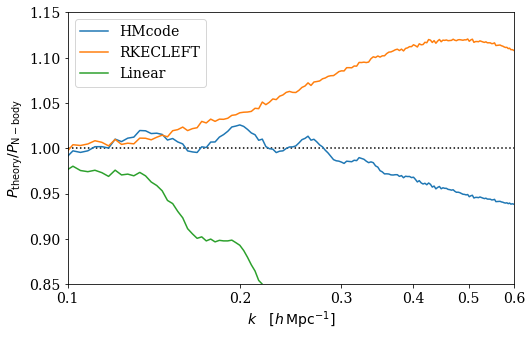

In [6]:
from scipy.interpolate import make_smoothing_spline
spl1 = make_smoothing_spline(k, ((pk_hmcode)/pmm_zcv), lam=1e-6)
spl2 = make_smoothing_spline(k, (((p1L_interp(k))/pmm_zcv)), lam=1e-6)
spl0 = make_smoothing_spline(k, (((pk_lin_trunc)/pmm_zcv)), lam=1e-6)

plt.figure(figsize=(8,5))
plt.axhline(1, c='k', ls=':')

# plt.loglog(k, spl1(k), alpha=0.5)
# plt.loglog(k, spl2(k), alpha=0.5)
# plt.loglog(k, spl0(k), alpha=0.5)

plt.semilogx(k, (((pk_hmcode)/pmm_zcv)), label='HMcode', c='C0')
plt.semilogx(k, (((p1L_interp(k))/pmm_zcv)), label='RKECLEFT', c='C1')
plt.semilogx(k, (((pk_lin_trunc)/pmm_zcv)), label='Linear', c='C2')

plt.xlim(0.1,0.6)
plt.ylim(0.93, 1.13)
plt.ylim(0.85, 1.15)

plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6], labels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

plt.xlabel(r'$k\quad [h\,{\rm Mpc}^{-1}]}$')
plt.ylabel(r'$P_{\rm theory}/P_{\rm N-body}$')
plt.legend()
plt.savefig('figures/Abacus_Ratio.pdf')
plt.show() 
